In [ ]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# --- Configuración Inicial ---
NUM_ROWS = 6000
START_DATE = datetime(2022, 1, 1)
END_DATE = datetime(2024, 5, 31)

productos = {
    "PROD-001": {"nombre": "Portátil Z1", "coste_prod": 250.75, "precio_venta": 499.99},
    "PROD-002": {"nombre": "Portátil Z1 Pro", "coste_prod": 450.50, "precio_venta": 899.99},
    "PROD-003": {"nombre": "Tarjeta Gráfica Eco", "coste_compra": 85.50, "precio_venta": 159.90},
    "PROD-004": {"nombre": "Tarjeta Gráfica Pro", "coste_compra": 180.20, "precio_venta": 349.50},
    "PROD-005": {"nombre": "Procesador Gamma", "coste_compra": 120.00, "precio_venta": 220.00},
    "PROD-006": {"nombre": "SSD 512GB", "coste_compra": 35.80, "precio_venta": 79.99},
    "PROD-007": {"nombre": "SSD 1TB", "coste_compra": 65.40, "precio_venta": 129.99},
    "PROD-008": {"nombre": "Batería Larga Duración", "coste_compra": 45.10, "precio_venta": 95.00},
    "PROD-009": {"nombre": "Monitor Curvo 27''", "coste_prod": 150.00, "precio_venta": 299.00},
    "PROD-010": {"nombre": "Webcam HD Pro", "coste_compra": 25.00, "precio_venta": 59.99},
}

proveedores = ["TechSupplies Inc.", "Componentes Globales", "PowerCell Co.", "VisionParts"]
clientes = ["Global Office", "PC Gamers World", "CorpTech Solutions", "Venta Directa Online", "EducaTech"]

# --- Generación de Datos Base ---
data = []
date_range = pd.to_datetime(pd.date_range(start=START_DATE, end=END_DATE, periods=NUM_ROWS)).sort_values()

for i in range(NUM_ROWS):
    tipo_movimiento = random.choices(["Compra", "Produccion", "Venta"], weights=[0.25, 0.20, 0.55], k=1)[0]
    prod_id = random.choice(list(productos.keys()))
    prod_info = productos[prod_id]

    # Asignar origen y proveedor/cliente
    origen = tipo_movimiento
    proveedor_cliente = "N/A"

    if tipo_movimiento == "Compra":
        # Solo componentes se compran
        if "coste_compra" not in prod_info:
            tipo_movimiento = "Produccion"
            origen = "Fabricacion"
        else:
            proveedor_cliente = random.choice(proveedores)

    if tipo_movimiento == "Produccion":
        # Solo productos finales se producen
        if "coste_prod" not in prod_info:
            # Si un componente es elegido para produccion, lo cambiamos a compra
            tipo_movimiento = "Compra"
            origen = "Compra"
            proveedor_cliente = random.choice(proveedores)
        else:
             origen = "Fabricacion"

    if tipo_movimiento == "Venta":
        proveedor_cliente = random.choice(clientes)

    # Cantidades y costes
    cantidad = 0
    costo_unitario = 0
    precio_venta_unitario = 0

    if tipo_movimiento == "Compra":
        cantidad = random.randint(50, 300)
        costo_unitario = prod_info.get("coste_compra", 0)
    elif tipo_movimiento == "Produccion":
        cantidad = random.randint(20, 100)
        costo_unitario = prod_info.get("coste_prod", 0)
    elif tipo_movimiento == "Venta":
        cantidad = -random.randint(5, 50)
        precio_venta_unitario = prod_info["precio_venta"]

    data.append({
        "ID_Transaccion": i + 1,
        "Fecha": date_range[i].strftime('%Y-%m-%d'),
        "Tipo_Movimiento": tipo_movimiento,
        "ID_Producto": prod_id,
        "Nombre_Producto": prod_info["nombre"],
        "Cantidad": cantidad,
        "Costo_Unitario": round(costo_unitario * random.uniform(0.98, 1.02), 2), # Pequeña variación
        "Precio_Venta_Unitario": round(precio_venta_unitario * random.uniform(0.99, 1.01), 2), # Pequeña variación
        "Origen": origen,
        "Proveedor_Cliente": proveedor_cliente
    })

df = pd.DataFrame(data)

# --- INYECCIÓN DE ERRORES ---

# 1. Error de tipeo en Nombre_Producto
# Cambiamos "Procesador Gamma" a "Procesador Gama" en un 30% de los casos.
mask = (df['ID_Producto'] == 'PROD-005') & (np.random.rand(len(df)) < 0.3)
df.loc[mask, 'Nombre_Producto'] = 'Procesador Gama'
print(f"Error 1 (tipeo) inyectado en {mask.sum()} filas para el producto PROD-005.")

# 2. Outlier/Valor anómalo en Cantidad
# Una venta con una cantidad absurdamente alta.
outlier_index = df[df['Tipo_Movimiento'] == 'Venta'].sample(1).index
df.loc[outlier_index, 'Cantidad'] = -5000
print(f"Error 2 (outlier) inyectado en la fila con índice: {outlier_index.values[0]}.")

# 3. Error de tipo de dato en Costo_Unitario
# Insertamos un string en un campo numérico.
error_type_indices = df[df['Tipo_Movimiento'] == 'Compra'].sample(3).index
df.loc[error_type_indices, 'Costo_Unitario'] = 'NO DISPONIBLE'
print(f"Error 3 (tipo de dato) inyectado en {len(error_type_indices)} filas.")

# 4. Error de tendencia
# Las ventas del PROD-009 caen a casi cero en los últimos 4 meses de datos a pesar de seguirse produciendo.
last_4_months = END_DATE - timedelta(days=120)
mask_tendencia = (df['ID_Producto'] == 'PROD-009') & (df['Tipo_Movimiento'] == 'Venta') & (pd.to_datetime(df['Fecha']) > last_4_months)
df.loc[mask_tendencia, 'Cantidad'] = -np.random.randint(1, 3, size=mask_tendencia.sum()) # Ventas muy bajas
print(f"Error 4 (tendencia) inyectado para PROD-009 en las {mask_tendencia.sum()} últimas ventas.")


# --- Guardar a CSV ---
df.to_csv("datos_empresa.csv", index=False, sep=';', decimal='.')
print("\nArchivo 'datos_empresa.csv' generado con 6000 filas y errores incluidos.")

Error 1 (tipeo) inyectado en 161 filas para el producto PROD-005.
Error 2 (outlier) inyectado en la fila con índice: 3237.
Error 3 (tipo de dato) inyectado en 3 filas.
Error 4 (tendencia) inyectado para PROD-009 en las 49 últimas ventas.

Archivo 'datos_empresa.csv' generado con 6000 filas y errores incluidos.


/tmp/ipython-input-1-121497219.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NO DISPONIBLE' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[error_type_indices, 'Costo_Unitario'] = 'NO DISPONIBLE'


In [ ]:
# Empezamos el análisis de los datos

# Instalar librerías si no están (seaborn suele estar, pero por si acaso)
!pip install seaborn

# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo para los gráficos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Librerías importadas y configuración lista.")

Librerías importadas y configuración lista.


In [ ]:
# Cargar el dataset. ¡Ojo con el separador y el decimal!
# El script generador usó ';' como separador y '.' como decimal.
df = pd.read_csv('datos_empresa.csv', sep=';', decimal='.')

# Convertir la columna 'Fecha' a tipo datetime para poder trabajar con ella
df['Fecha'] = pd.to_datetime(df['Fecha'])

# --- Inspección Inicial ---

# 1. Ver la información general del DataFrame
print("--- Información General (df.info()) ---")
df.info()
# OBSERVACIÓN INICIAL: ¡Costo_Unitario es de tipo 'object' (texto) y no numérico!
# Esto se debe al error de tipo de dato ('NO DISPONIBLE') que introdujimos.

print("\n--- Descripción Estadística (df.describe()) ---")
print(df.describe())
# OBSERVACIÓN INICIAL: En 'Cantidad', el valor mínimo es -5000.
# Esto es muy diferente del percentil 25 (-30). ¡Es nuestro outlier!

print("\n--- Nombres de Productos Únicos ---")
print(sorted(df['Nombre_Producto'].unique()))
# OBSERVACIÓN INICIAL: Vemos 'Procesador Gama' y 'Procesador Gamma'. ¡Es nuestro error de tipeo!

--- Información General (df.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID_Transaccion         6000 non-null   int64         
 1   Fecha                  6000 non-null   datetime64[ns]
 2   Tipo_Movimiento        6000 non-null   object        
 3   ID_Producto            6000 non-null   object        
 4   Nombre_Producto        6000 non-null   object        
 5   Cantidad               6000 non-null   int64         
 6   Costo_Unitario         6000 non-null   object        
 7   Precio_Venta_Unitario  6000 non-null   float64       
 8   Origen                 6000 non-null   object        
 9   Proveedor_Cliente      5195 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 468.9+ KB

--- Descripción Estadística (df.describe()) ---
       ID_Tra

In [ ]:
# --- Proceso de Limpieza ---

# Problema 1: Corregir el error de tipeo en 'Nombre_Producto'
print("Corrigiendo error de tipeo 'Procesador Gama' -> 'Procesador Gamma'...")
df['Nombre_Producto'] = df['Nombre_Producto'].replace('Procesador Gama', 'Procesador Gamma')
print("Verificación:", 'Procesador Gama' in df['Nombre_Producto'].unique()) # Debería ser False

# Problema 2: Corregir el error de tipo de dato en 'Costo_Unitario'
print("\nCorrigiendo error de tipo de dato en 'Costo_Unitario'...")
# pd.to_numeric con errors='coerce' convertirá los textos 'NO DISPONIBLE' a NaN (Not a Number)
df['Costo_Unitario'] = pd.to_numeric(df['Costo_Unitario'], errors='coerce')

# Ahora, imputamos los valores NaN. Una buena estrategia es usar el costo promedio para ese producto.
# Creamos un mapa de ID_Producto -> Costo Promedio
costo_promedio_por_producto = df.groupby('ID_Producto')['Costo_Unitario'].transform('mean')
df['Costo_Unitario'].fillna(costo_promedio_por_producto, inplace=True)
print("Valores nulos en 'Costo_Unitario' después de la imputación:", df['Costo_Unitario'].isnull().sum())


# Problema 3: Manejar el outlier en 'Cantidad'
print("\nManejando el outlier en 'Cantidad'...")
# Identificamos el outlier
outlier_mask = df['Cantidad'] < -1000
print("Fila con el outlier encontrada:\n", df[outlier_mask])

# Una estrategia es reemplazarlo por un valor más razonable, como la mediana de ventas de ese producto.
id_producto_outlier = df[outlier_mask]['ID_Producto'].iloc[0]
mediana_ventas = df[(df['ID_Producto'] == id_producto_outlier) & (df['Tipo_Movimiento'] == 'Venta')]['Cantidad'].median()
df.loc[outlier_mask, 'Cantidad'] = mediana_ventas
print(f"Outlier reemplazado por la mediana de ventas del producto: {mediana_ventas}")

print("\n--- Resumen de limpieza ---")
df.info() # Ahora Costo_Unitario es float64
print("\n", df.describe()) # Ahora el min de Cantidad es razonable

Corrigiendo error de tipeo 'Procesador Gama' -> 'Procesador Gamma'...
Verificación: False

Corrigiendo error de tipo de dato en 'Costo_Unitario'...
Valores nulos en 'Costo_Unitario' después de la imputación: 0

Manejando el outlier en 'Cantidad'...
Fila con el outlier encontrada:
       ID_Transaccion      Fecha Tipo_Movimiento ID_Producto Nombre_Producto  \
3237            3238 2023-04-21           Venta    PROD-010   Webcam HD Pro   

      Cantidad  Costo_Unitario  Precio_Venta_Unitario Origen Proveedor_Cliente  
3237     -5000             0.0                  59.66  Venta   PC Gamers World  
Outlier reemplazado por la mediana de ventas del producto: -25.0

--- Resumen de limpieza ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID_Transaccion         6000 non-null   int64         
 1   Fecha         

/tmp/ipython-input-4-4026152527.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Costo_Unitario'].fillna(costo_promedio_por_producto, inplace=True)


In [ ]:
# --- Creación de Nuevas Columnas para el Análisis ---

# 1. Ingresos por Venta (solo en filas de Venta)
df['Ingresos'] = np.where(df['Tipo_Movimiento'] == 'Venta', -df['Cantidad'] * df['Precio_Venta_Unitario'], 0)

# 2. Coste de la Mercancía Vendida (CMV)
# Esta es la parte más compleja y la que demuestra un análisis profundo.
# El coste no está en la fila de venta, debemos asociarlo.
# Primero, calculamos el costo promedio de adquisición (Compra o Producción) para cada producto.
costos_adquisicion = df[df['Tipo_Movimiento'].isin(['Compra', 'Produccion'])]
mapa_costo_promedio = costos_adquisicion.groupby('ID_Producto')['Costo_Unitario'].mean()

# Mapeamos ese costo a las filas de venta
df['Costo_Promedio_Producto'] = df['ID_Producto'].map(mapa_costo_promedio)
df['Coste_Venta'] = np.where(df['Tipo_Movimiento'] == 'Venta', -df['Cantidad'] * df['Costo_Promedio_Producto'], 0)

# 3. Margen Bruto por transacción
df['Margen'] = df['Ingresos'] - df['Coste_Venta']

# 4. Stock Acumulado (Running Total)
# Es crucial ordenar por fecha para que el cálculo acumulado sea correcto.
df = df.sort_values(by=['ID_Producto', 'Fecha'])
df['Stock_Acumulado'] = df.groupby('ID_Producto')['Cantidad'].cumsum()

print("\nDataFrame enriquecido con nuevas métricas. Mostrando las últimas filas de un producto:")
print(df[df['ID_Producto'] == 'PROD-001'].tail())


DataFrame enriquecido con nuevas métricas. Mostrando las últimas filas de un producto:
      ID_Transaccion      Fecha Tipo_Movimiento ID_Producto Nombre_Producto  \
5933            5934 2024-05-21           Venta    PROD-001     Portátil Z1   
5962            5963 2024-05-25           Venta    PROD-001     Portátil Z1   
5984            5985 2024-05-28           Venta    PROD-001     Portátil Z1   
5985            5986 2024-05-28           Venta    PROD-001     Portátil Z1   
5998            5999 2024-05-30           Venta    PROD-001     Portátil Z1   

      Cantidad  Costo_Unitario  Precio_Venta_Unitario Origen  \
5933       -44             0.0                 496.67  Venta   
5962       -15             0.0                 503.54  Venta   
5984       -12             0.0                 504.11  Venta   
5985       -37             0.0                 499.55  Venta   
5998       -50             0.0                 503.07  Venta   

       Proveedor_Cliente  Ingresos  Costo_Promedio_P

/tmp/ipython-input-6-2810134198.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x=rentabilidad_productos.values, y=rentabilidad_productos.index, palette='viridis')


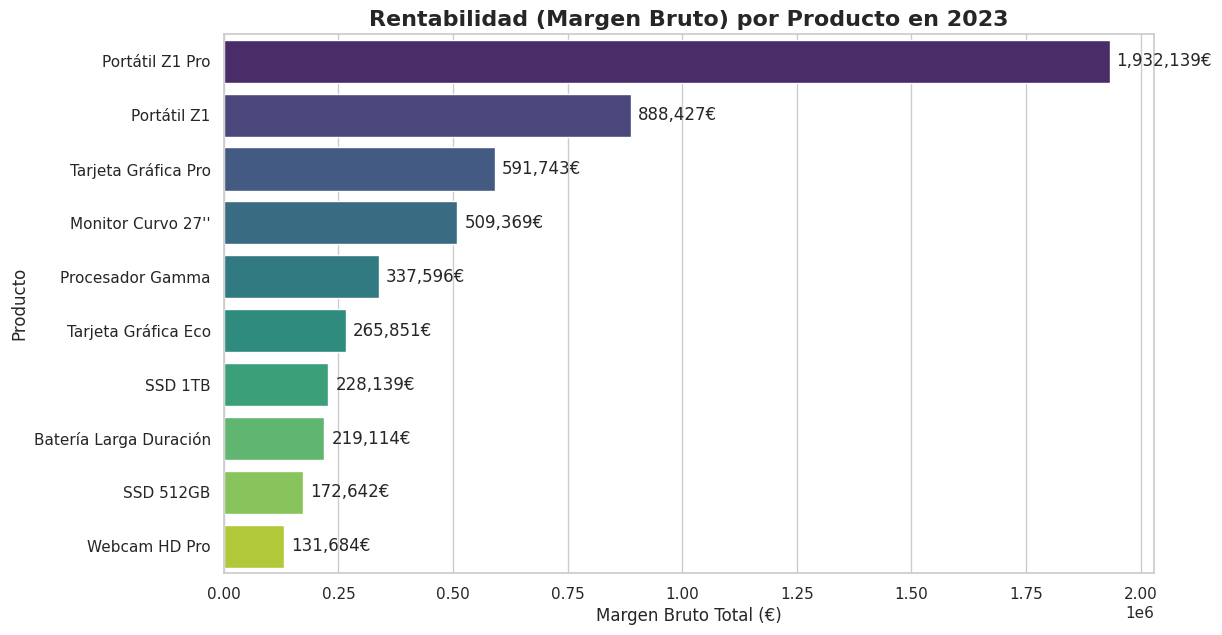

In [ ]:
# Filtrar por el último año completo: 2023
df_2023 = df[df['Fecha'].dt.year == 2023].copy()

# Agrupar por producto y sumar el margen
rentabilidad_productos = df_2023.groupby('Nombre_Producto')['Margen'].sum().sort_values(ascending=False)

# Crear el gráfico
plt.figure(figsize=(12, 7))
ax1 = sns.barplot(x=rentabilidad_productos.values, y=rentabilidad_productos.index, palette='viridis')
ax1.set_title('Rentabilidad (Margen Bruto) por Producto en 2023', fontsize=16, weight='bold')
ax1.set_xlabel('Margen Bruto Total (€)')
ax1.set_ylabel('Producto')
# Añadir etiquetas con los valores
for container in ax1.containers:
    ax1.bar_label(container, fmt='{:,.0f}€', label_type='edge', padding=5)

# Guardamos el gráfico para el dashboard final
grafico_rentabilidad = plt.gcf()


DataFrame con la nueva columna 'Margen_Neto'. Mostrando las últimas filas de un producto:
      ID_Transaccion      Fecha Tipo_Movimiento ID_Producto Nombre_Producto  \
5933            5934 2024-05-21           Venta    PROD-001     Portátil Z1   
5962            5963 2024-05-25           Venta    PROD-001     Portátil Z1   
5984            5985 2024-05-28           Venta    PROD-001     Portátil Z1   
5985            5986 2024-05-28           Venta    PROD-001     Portátil Z1   
5998            5999 2024-05-30           Venta    PROD-001     Portátil Z1   

      Cantidad  Costo_Unitario  Precio_Venta_Unitario Origen  \
5933       -44             0.0                 496.67  Venta   
5962       -15             0.0                 503.54  Venta   
5984       -12             0.0                 504.11  Venta   
5985       -37             0.0                 499.55  Venta   
5998       -50             0.0                 503.07  Venta   

       Proveedor_Cliente  Ingresos  Costo_Promedi

/tmp/ipython-input-8-1527443138.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x=rentabilidad_neta_productos.values, y=rentabilidad_neta_productos.index, palette='viridis')


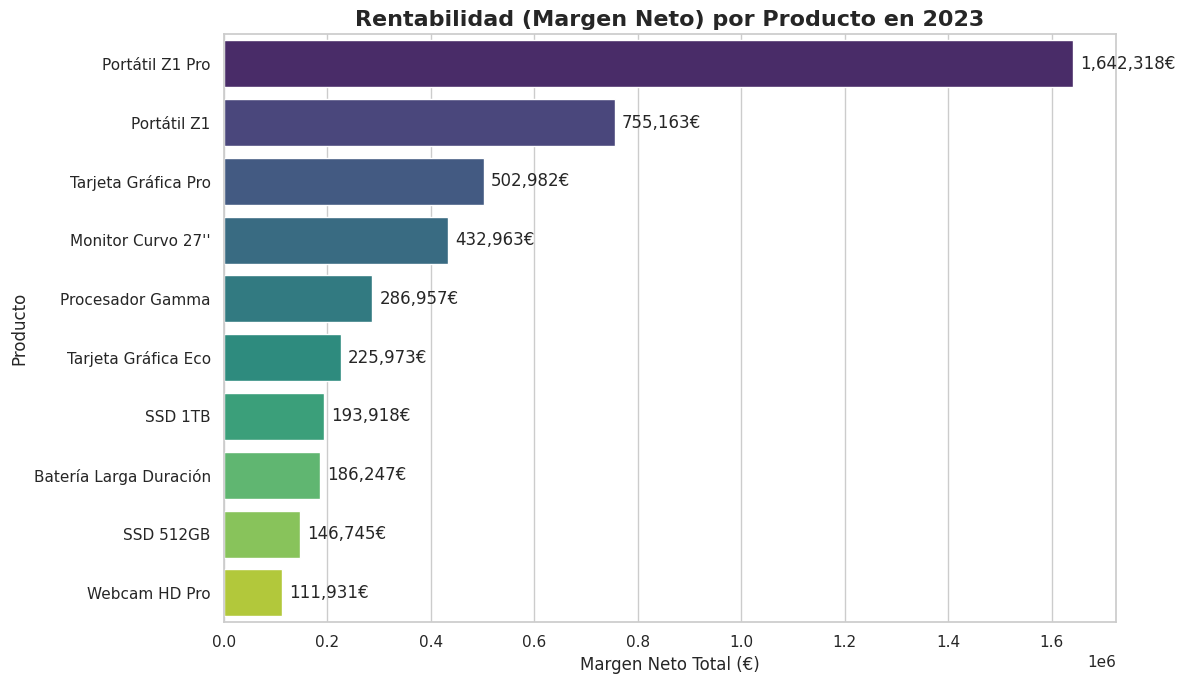

In [ ]:
# --- Creación de Columna de Margen Neto ---

# Para el margen neto, necesitaríamos considerar otros gastos (marketing, operativos, etc.).
# Como no tenemos esos datos en el dataset, haremos una simplificación:
# Margen Neto = Margen Bruto - (Margen Bruto * %_Gastos_Operativos)
# Asumiremos un porcentaje fijo de gastos operativos sobre el margen bruto para este ejemplo.
PORCENTAJE_GASTOS_OPERATIVOS = 0.15 # 15%

df['Margen_Neto'] = df['Margen'] * (1 - PORCENTAJE_GASTOS_OPERATIVOS)

print("\nDataFrame con la nueva columna 'Margen_Neto'. Mostrando las últimas filas de un producto:")
print(df[df['ID_Producto'] == 'PROD-001'].tail())

# --- Gráfico de Barras de Rentabilidad (Margen Neto) ---
# Agrupar por producto y sumar el margen neto para el año 2023
df_2023 = df[df['Fecha'].dt.year == 2023].copy()
rentabilidad_neta_productos = df_2023.groupby('Nombre_Producto')['Margen_Neto'].sum().sort_values(ascending=False)


plt.figure(figsize=(12, 7))
ax1 = sns.barplot(x=rentabilidad_neta_productos.values, y=rentabilidad_neta_productos.index, palette='viridis')
ax1.set_title('Rentabilidad (Margen Neto) por Producto en 2023', fontsize=16, weight='bold')
ax1.set_xlabel('Margen Neto Total (€)')
ax1.set_ylabel('Producto')

# Añadir etiquetas con los valores
for container in ax1.containers:
    ax1.bar_label(container, fmt='{:,.0f}€', label_type='edge', padding=5)

plt.tight_layout() # Ajustar el layout para que las etiquetas no se corten
plt.show() # Mostrar el gráfico

/tmp/ipython-input-9-3805136297.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x=unidades_vendidas_por_producto.values, y=unidades_vendidas_por_producto.index, palette='viridis')


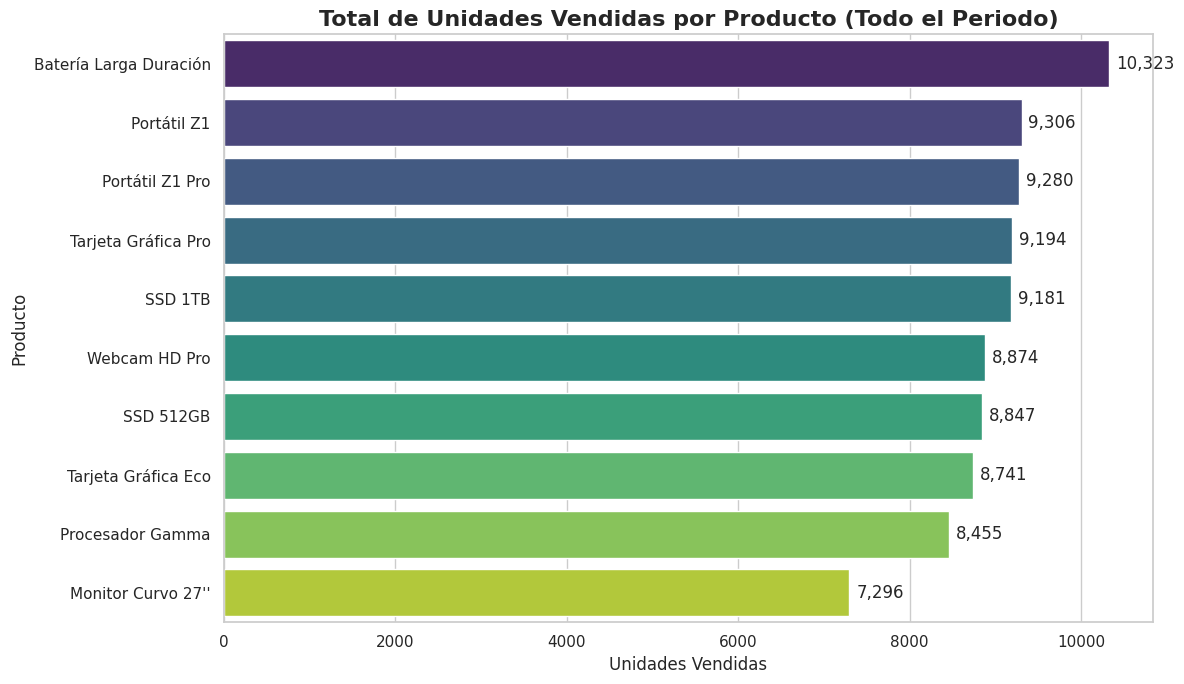

In [ ]:
# --- Gráfico de Unidades Vendidas por Producto ---

# 1. Filtrar solo las transacciones de 'Venta'
df_ventas = df[df['Tipo_Movimiento'] == 'Venta'].copy()

# 2. Agrupar por producto y sumar las cantidades vendidas (usamos el valor absoluto)
# La cantidad en ventas es negativa, por eso tomamos el valor absoluto para contar unidades vendidas.
unidades_vendidas_por_producto = df_ventas.groupby('Nombre_Producto')['Cantidad'].sum().abs().sort_values(ascending=False)

# 3. Crear el gráfico de barras
plt.figure(figsize=(12, 7))
ax2 = sns.barplot(x=unidades_vendidas_por_producto.values, y=unidades_vendidas_por_producto.index, palette='viridis')
ax2.set_title('Total de Unidades Vendidas por Producto (Todo el Periodo)', fontsize=16, weight='bold')
ax2.set_xlabel('Unidades Vendidas')
ax2.set_ylabel('Producto')

# Añadir etiquetas con los valores
for container in ax2.containers:
    ax2.bar_label(container, fmt='{:,.0f}', label_type='edge', padding=5)

plt.tight_layout() # Ajustar el layout
plt.show() # Mostrar el gráfico

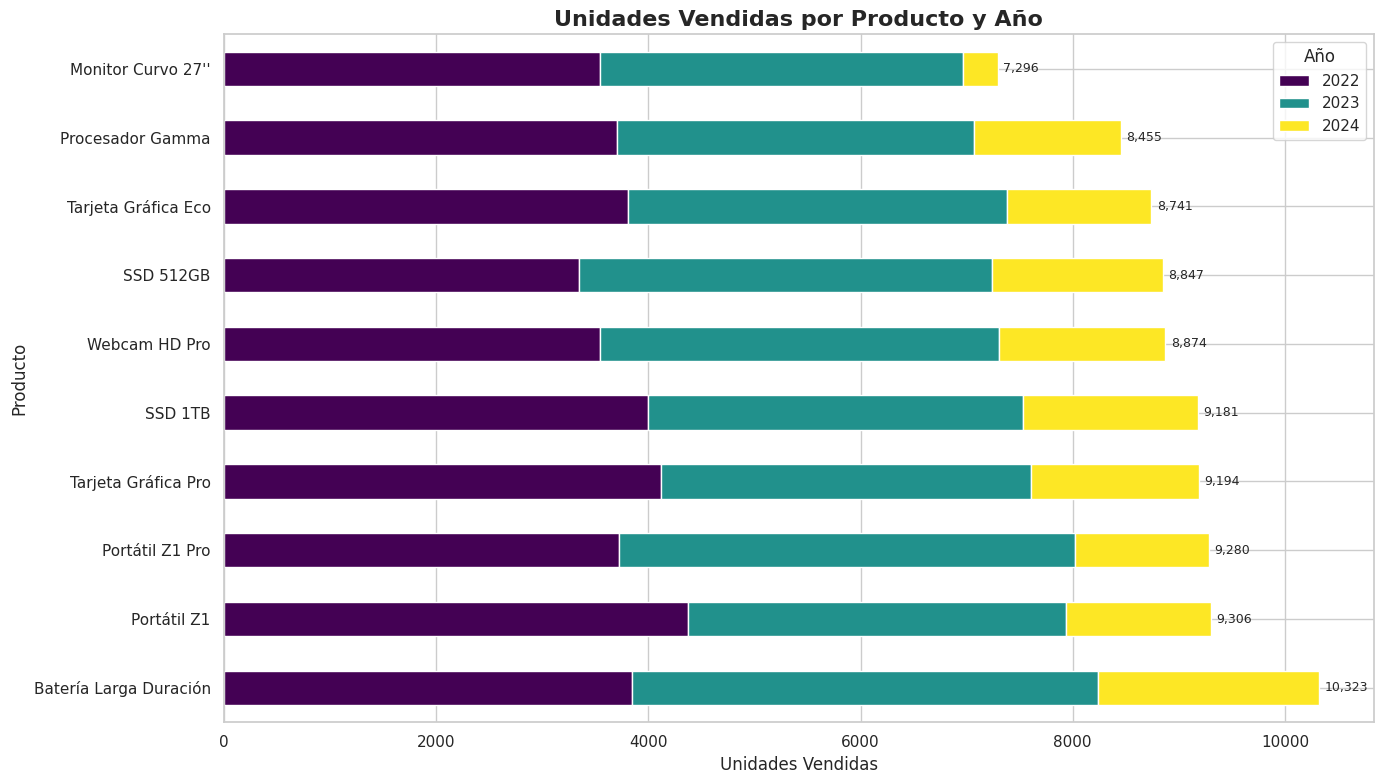

In [ ]:
# --- Gráfico de Unidades Vendidas por Producto por Año (Apilado) ---

# 1. Filtrar solo las transacciones de 'Venta'
df_ventas = df[df['Tipo_Movimiento'] == 'Venta'].copy()

# Extraer el año de la fecha
df_ventas['Año'] = df_ventas['Fecha'].dt.year

# 2. Agrupar por producto y año, y sumar las cantidades vendidas (usamos el valor absoluto)
unidades_vendidas_por_producto_año = df_ventas.groupby(['Nombre_Producto', 'Año'])['Cantidad'].sum().abs().reset_index()

# 3. Pivotear la tabla para el gráfico apilado
unidades_pivot = unidades_vendidas_por_producto_año.pivot(index='Nombre_Producto', columns='Año', values='Cantidad').fillna(0)

# Calcular el total de unidades vendidas por producto para ordenar
unidades_pivot['Total'] = unidades_pivot.sum(axis=1)
unidades_pivot = unidades_pivot.sort_values(by='Total', ascending=False)

# Eliminar la columna 'Total' para el gráfico apilado, pero la usamos para el orden
unidades_para_grafico = unidades_pivot.drop(columns='Total')

# 4. Crear el gráfico de barras apiladas
plt.figure(figsize=(14, 8))
ax3 = unidades_para_grafico.plot(kind='barh', stacked=True, colormap='viridis', ax=plt.gca())

ax3.set_title('Unidades Vendidas por Producto y Año', fontsize=16, weight='bold')
ax3.set_xlabel('Unidades Vendidas')
ax3.set_ylabel('Producto')

# Añadir etiquetas con los valores totales al final de cada barra apilada
for index, total in enumerate(unidades_pivot['Total']):
    ax3.text(total + 50, index, f'{total:,.0f}', va='center', fontsize=9) # Ajustar posición y formato

plt.legend(title='Año')
plt.tight_layout() # Ajustar el layout
plt.show() # Mostrar el gráfico

<Figure size 1200x700 with 0 Axes>

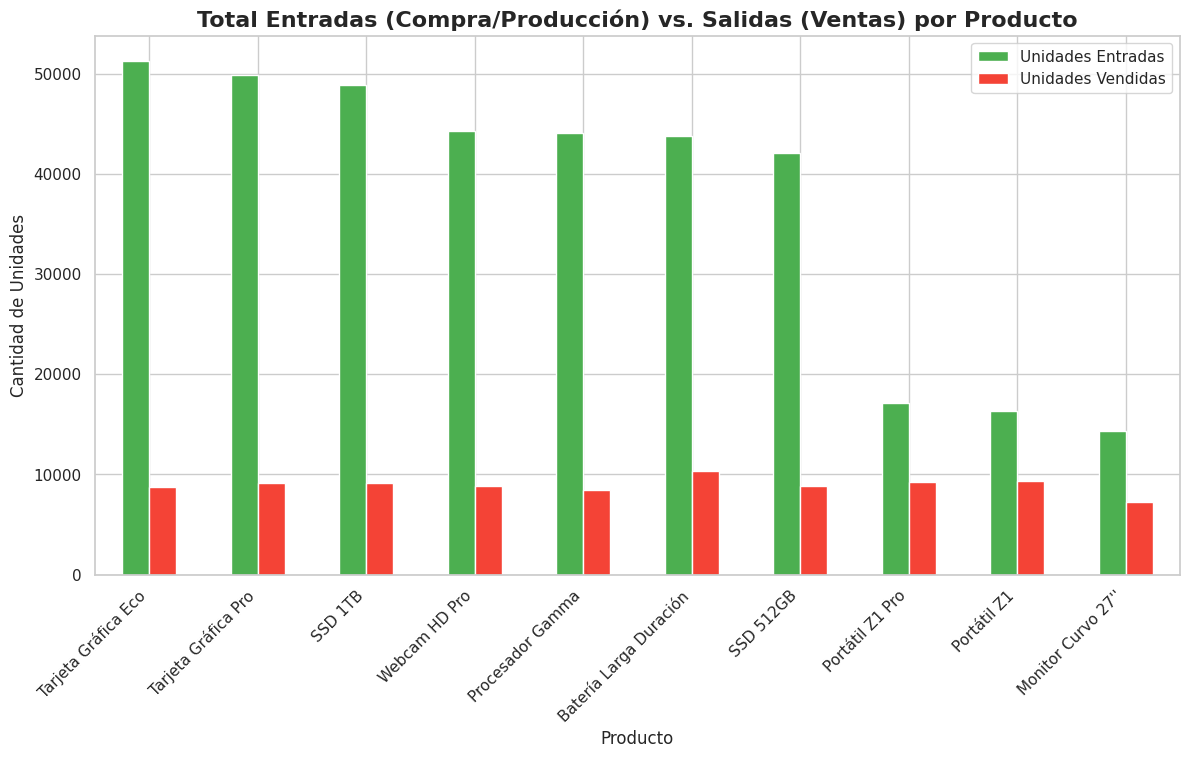

In [ ]:
# Analizar el stock final
stock_final = df.groupby('Nombre_Producto')['Stock_Acumulado'].last().sort_values(ascending=False)

# Analizar entradas vs. salidas
movimientos = df.copy()
movimientos['Entradas'] = np.where(movimientos['Tipo_Movimiento'].isin(['Compra', 'Produccion']), movimientos['Cantidad'], 0)
movimientos['Salidas'] = np.where(movimientos['Tipo_Movimiento'] == 'Venta', -movimientos['Cantidad'], 0)
rotacion = movimientos.groupby('Nombre_Producto')[['Entradas', 'Salidas']].sum()
rotacion['Stock_Final_Calculado'] = rotacion['Entradas'] - rotacion['Salidas']

# Crear el gráfico
plt.figure(figsize=(12, 7))
ax2 = rotacion[['Entradas', 'Salidas']].sort_values(by='Entradas', ascending=False).plot(
    kind='bar',
    stacked=False,
    figsize=(14, 7),
    color=['#4CAF50', '#F44336']
)
plt.title('Total Entradas (Compra/Producción) vs. Salidas (Ventas) por Producto', fontsize=16, weight='bold')
plt.ylabel('Cantidad de Unidades')
plt.xlabel('Producto')
plt.xticks(rotation=45, ha='right')
plt.legend(['Unidades Entradas', 'Unidades Vendidas'])

# Guardamos el gráfico
grafico_rotacion = plt.gcf()

/tmp/ipython-input-12-872316725.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ventas_por_mes = ventas_mensuales.groupby(['Nombre_Producto', pd.Grouper(key='Fecha', freq='M')])['Cantidad_Vendida'].sum().reset_index()


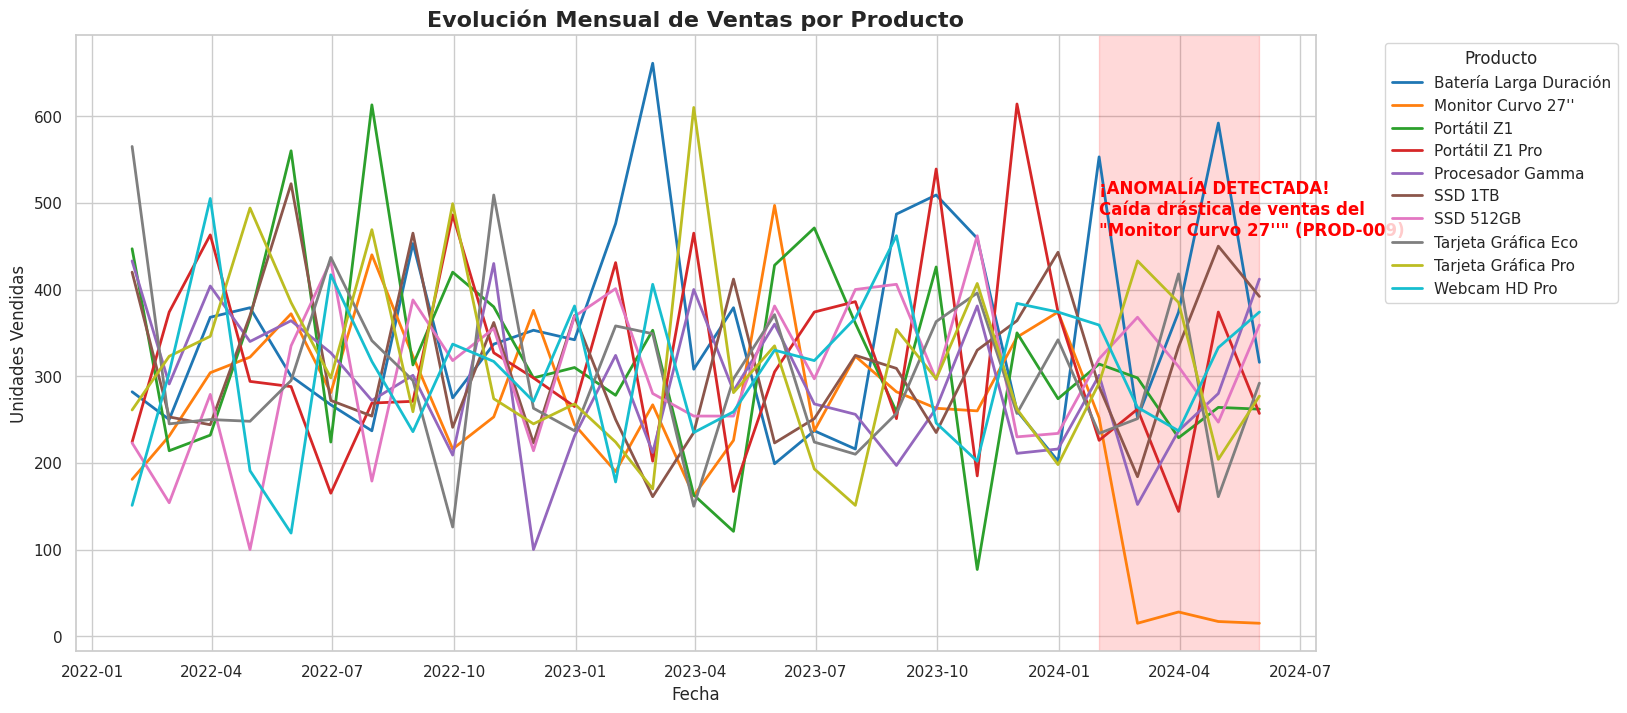

In [ ]:
# Preparar datos para el análisis de series temporales
# Agrupar ventas por mes y producto
ventas_mensuales = df[df['Tipo_Movimiento'] == 'Venta'].copy()
ventas_mensuales['Cantidad_Vendida'] = -ventas_mensuales['Cantidad']
ventas_por_mes = ventas_mensuales.groupby(['Nombre_Producto', pd.Grouper(key='Fecha', freq='M')])['Cantidad_Vendida'].sum().reset_index()

# Crear el gráfico de series temporales
plt.figure(figsize=(16, 8))
ax3 = sns.lineplot(data=ventas_por_mes, x='Fecha', y='Cantidad_Vendida', hue='Nombre_Producto', lw=2, palette='tab10')
ax3.set_title('Evolución Mensual de Ventas por Producto', fontsize=16, weight='bold')
ax3.set_ylabel('Unidades Vendidas')
ax3.set_xlabel('Fecha')
plt.legend(title='Producto', bbox_to_anchor=(1.05, 1), loc='upper left')

# Resaltar la anomalía
# Fecha a partir de la cual el error de tendencia fue inyectado (últimos 4 meses)
fecha_anomalia = df['Fecha'].max() - pd.DateOffset(months=4)
ax3.axvspan(fecha_anomalia, df['Fecha'].max(), color='red', alpha=0.15)
ax3.text(fecha_anomalia, ventas_por_mes['Cantidad_Vendida'].max()*0.8, '¡ANOMALÍA DETECTADA!\nCaída drástica de ventas del\n"Monitor Curvo 27\'\'" (PROD-009)',
         fontsize=12, color='red', weight='bold', verticalalignment='top')


# Guardamos el gráfico
grafico_tendencias = plt.gcf()

/tmp/ipython-input-18-1491246816.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axs[0, 0], x=rentabilidad_display.values, y=rentabilidad_display.index, palette='coolwarm')
/tmp/ipython-input-18-1491246816.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axs[0, 1], x=stock_final.values, y=stock_final.index, palette='plasma')


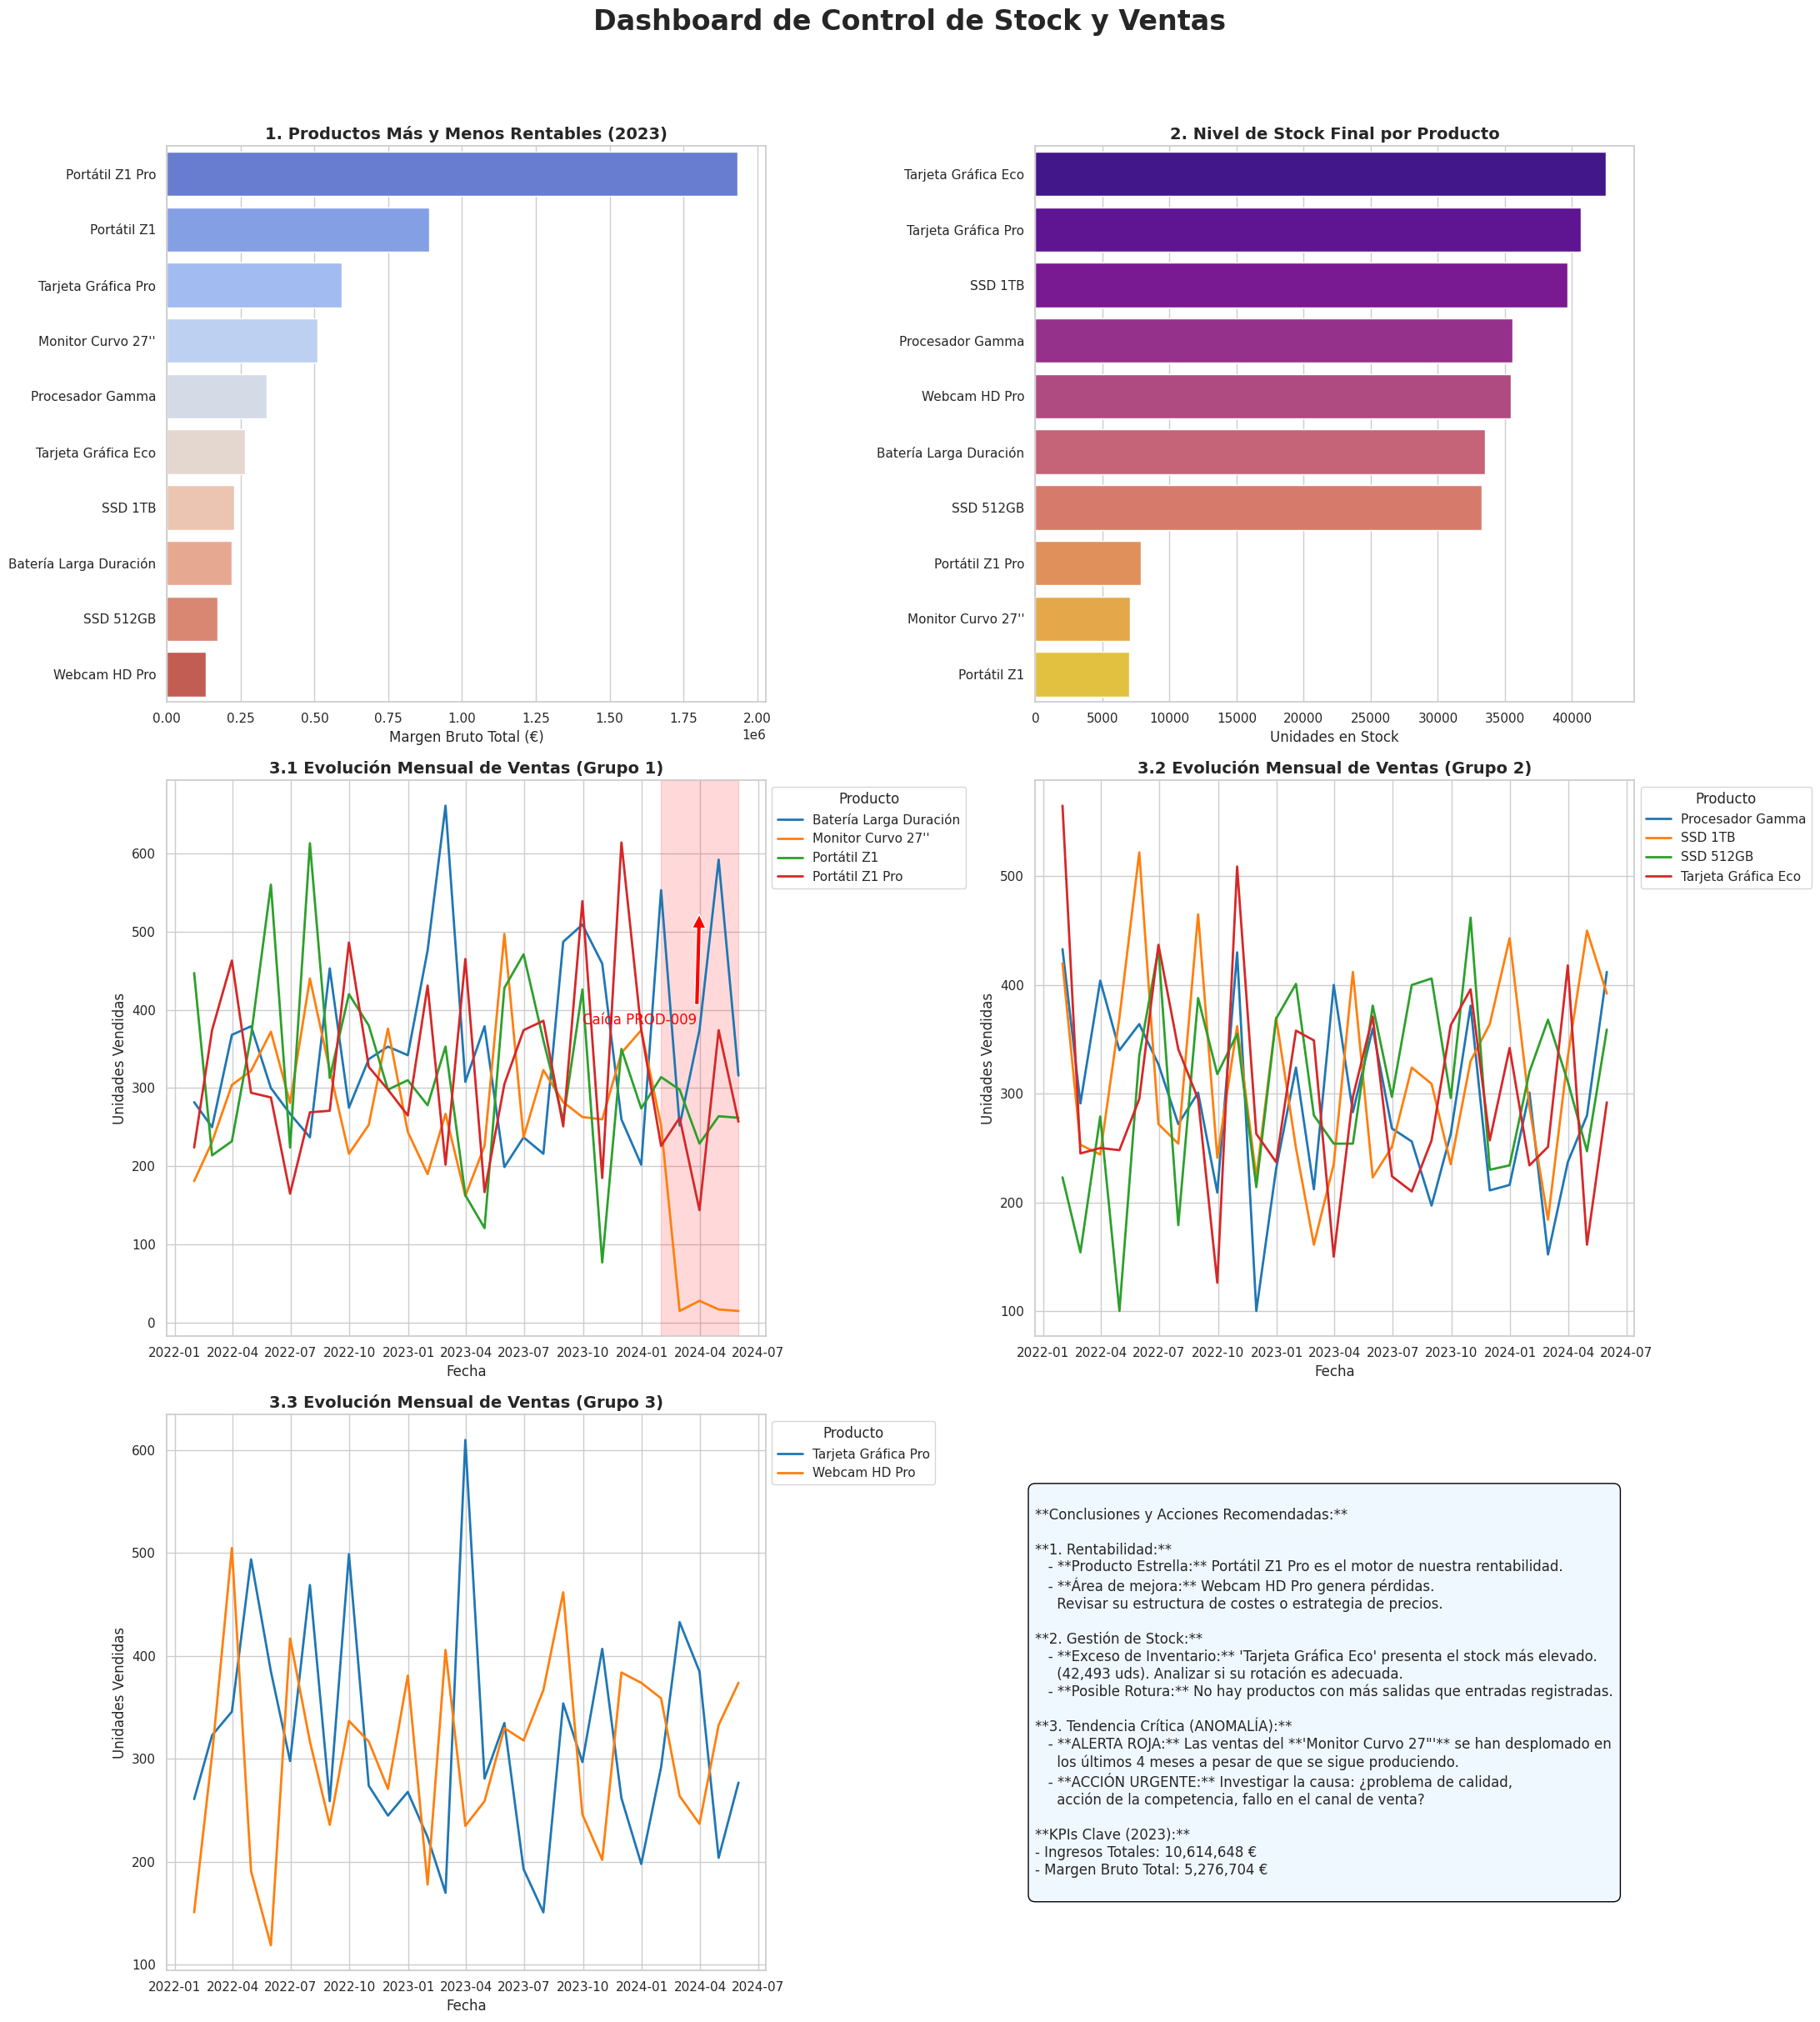

In [ ]:
# --- Creación del Dashboard Consolidado ---
fig, axs = plt.subplots(3, 2, figsize=(22, 24)) # Aumentar filas para los subgráficos de tendencias
fig.suptitle('Dashboard de Control de Stock y Ventas', fontsize=24, weight='bold', y=1.01)

# --- Gráfico 1: Rentabilidad (Top 5 y Bottom 5) ---
rentabilidad_top5 = rentabilidad_productos.head(5)
rentabilidad_bottom5 = rentabilidad_productos.tail(5)
rentabilidad_display = pd.concat([rentabilidad_top5, rentabilidad_bottom5])
sns.barplot(ax=axs[0, 0], x=rentabilidad_display.values, y=rentabilidad_display.index, palette='coolwarm')
axs[0, 0].set_title('1. Productos Más y Menos Rentables (2023)', fontsize=14, weight='bold')
axs[0, 0].set_xlabel('Margen Bruto Total (€)')
axs[0, 0].set_ylabel('')

# --- Gráfico 2: Nivel de Stock Final ---
sns.barplot(ax=axs[0, 1], x=stock_final.values, y=stock_final.index, palette='plasma')
axs[0, 1].set_title('2. Nivel de Stock Final por Producto', fontsize=14, weight='bold')
axs[0, 1].set_xlabel('Unidades en Stock')
axs[0, 1].set_ylabel('')

# --- Gráfico 3: Tendencias de Ventas (Dividido por Grupos) ---

# Definir grupos de productos (ejemplo: 3 grupos)
productos_lista = ventas_por_mes['Nombre_Producto'].unique()
num_productos = len(productos_lista)
productos_por_grupo = (num_productos + 2) // 3 # Asegurar que todos los productos estén en un grupo
grupos_productos = [productos_lista[i:i + productos_por_grupo] for i in range(0, num_productos, productos_por_grupo)]

row_idx = 1 # Empezar en la segunda fila para los gráficos de tendencias
col_idx = 0

for i, grupo in enumerate(grupos_productos):
    data_grupo = ventas_por_mes[ventas_por_mes['Nombre_Producto'].isin(grupo)]
    sns.lineplot(ax=axs[row_idx, col_idx], data=data_grupo, x='Fecha', y='Cantidad_Vendida', hue='Nombre_Producto', lw=2, palette='tab10')
    axs[row_idx, col_idx].set_title(f'3.{i+1} Evolución Mensual de Ventas (Grupo {i+1})', fontsize=14, weight='bold')
    axs[row_idx, col_idx].set_ylabel('Unidades Vendidas')
    axs[row_idx, col_idx].set_xlabel('Fecha')
    axs[row_idx, col_idx].legend(title='Producto', loc='upper left', bbox_to_anchor=(1, 1))

    # Resaltar anomalía si el producto PROD-009 está en este grupo
    if "Monitor Curvo 27''" in grupo:
        axs[row_idx, col_idx].axvspan(fecha_anomalia, df['Fecha'].max(), color='red', alpha=0.15)
        axs[row_idx, col_idx].annotate('Caída PROD-009', xy=(df['Fecha'].max() - pd.DateOffset(months=2), data_grupo['Cantidad_Vendida'].max()*0.8),
                                       xytext=(df['Fecha'].max() - pd.DateOffset(months=8), data_grupo['Cantidad_Vendida'].max()*0.6),
                                       arrowprops=dict(facecolor='red', shrink=0.05),
                                       fontsize=12, color='red', verticalalignment='top')


    col_idx += 1
    if col_idx > 1:
        col_idx = 0
        row_idx += 1

# --- Panel 4: KPIs y Conclusiones Clave ---
# Asegurarse de que el panel de texto esté en una posición correcta después de los gráficos de tendencias
if col_idx == 0: # Si el último gráfico de tendencias terminó en la columna 0
    axs[row_idx, 1].axis('off') # Ocultar el eje si no se usó para un gráfico
    axs[row_idx, 0].axis('off') # Ocultar el eje si no se usó para un gráfico
    text_panel_ax = axs[row_idx, 0] # Usar el primer eje de la última fila
elif col_idx == 1: # Si el último gráfico de tendencias terminó en la columna 1
     axs[row_idx, 1].axis('off') # Ocultar el eje si no se usó para un gráfico
     text_panel_ax = axs[row_idx, 1] # Usar el segundo eje de la última fila


text_panel_ax.axis('off') # Ocultar ejes para el panel de texto

# Calcular KPIs
margen_total_2023 = df_2023['Margen'].sum()
ingresos_totales_2023 = df_2023['Ingresos'].sum()
producto_mas_vendido = df_2023[df_2023['Tipo_Movimiento']=='Venta'].groupby('Nombre_Producto')['Cantidad'].sum().abs().idxmax()
producto_con_mas_stock = stock_final.idxmax()

# Check if there are products with more sales than entries before accessing index
productos_con_salidas_mayores = rotacion[rotacion['Salidas'] > rotacion['Entradas']].index
if not productos_con_salidas_mayores.empty:
    producto_con_riesgo_rotura = productos_con_salidas_mayores[0]
    riesgo_rotura_text = f"   - **Posible Rotura:** '{producto_con_riesgo_rotura}' tiene más salidas que entradas.\n     ¡Riesgo de rotura de stock!"
else:
    riesgo_rotura_text = "   - **Posible Rotura:** No hay productos con más salidas que entradas registradas."

# Texto de conclusiones
insights_text = f"""
**Conclusiones y Acciones Recomendadas:**

**1. Rentabilidad:**
   - **Producto Estrella:** {rentabilidad_productos.index[0]} es el motor de nuestra rentabilidad.
   - **Área de mejora:** {rentabilidad_productos.index[-1]} genera pérdidas.
     Revisar su estructura de costes o estrategia de precios.

**2. Gestión de Stock:**
   - **Exceso de Inventario:** '{producto_con_mas_stock}' presenta el stock más elevado.
     ({stock_final.max():,.0f} uds). Analizar si su rotación es adecuada.
{riesgo_rotura_text}

**3. Tendencia Crítica (ANOMALÍA):**
   - **ALERTA ROJA:** Las ventas del **'Monitor Curvo 27"'** se han desplomado en
     los últimos 4 meses a pesar de que se sigue produciendo.
   - **ACCIÓN URGENTE:** Investigar la causa: ¿problema de calidad,
     acción de la competencia, fallo en el canal de venta?

**KPIs Clave (2023):**
- Ingresos Totales: {ingresos_totales_2023:,.0f} €
- Margen Bruto Total: {margen_total_2023:,.0f} €
"""
text_panel_ax.text(0, 0.5, insights_text, fontsize=12, va='center', ha='left',
               bbox=dict(boxstyle="round,pad=0.5", fc='aliceblue', ec='black', lw=1))


plt.tight_layout(rect=[0, 0, 1, 0.98]) # Ajustar para el título principal y dejar espacio arriba
plt.show()

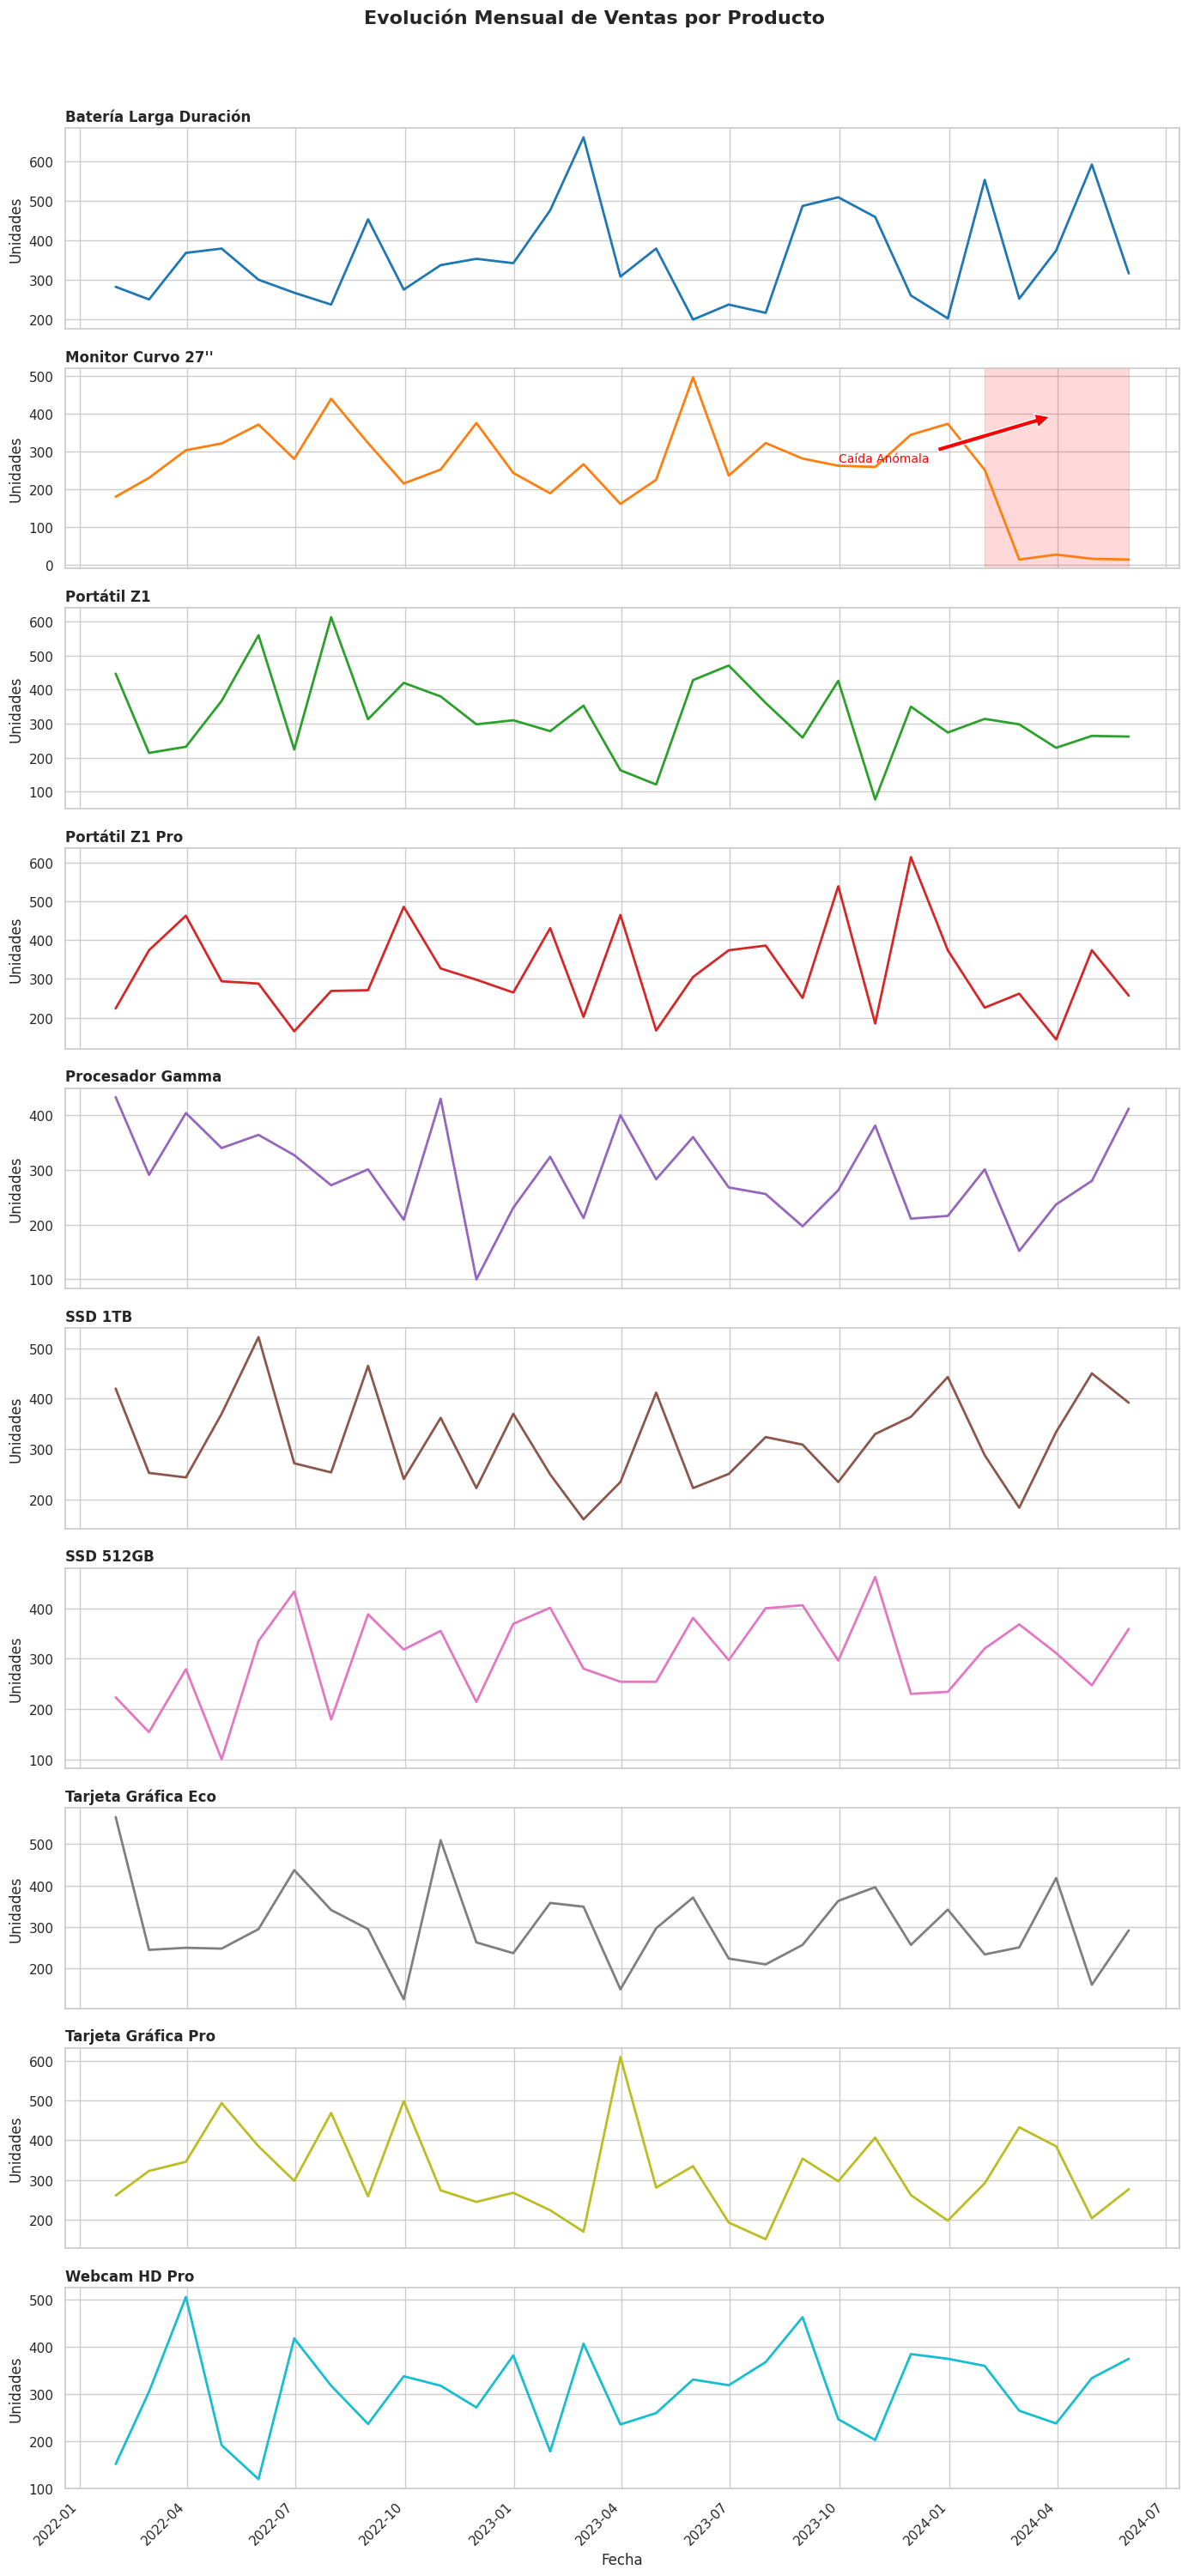

In [ ]:
# --- Gráfico de Tendencias de Ventas (Subgráficos Individuales) ---

# Preparar datos para el análisis de series temporales (reutilizamos ventas_por_mes)
# Asegurarnos de que todos los productos estén presentes en el índice para subplots
productos_lista = ventas_por_mes['Nombre_Producto'].unique()
num_productos = len(productos_lista)

# Crear subplots: una fila por producto
fig, axs = plt.subplots(num_productos, 1, figsize=(14, num_productos * 3), sharex=True) # Aumentar el tamaño vertical

fig.suptitle('Evolución Mensual de Ventas por Producto', fontsize=16, weight='bold', y=1.0)

# Iterar sobre cada producto y crear su subgráfico
for i, producto in enumerate(productos_lista):
    data_producto = ventas_por_mes[ventas_por_mes['Nombre_Producto'] == producto]

    sns.lineplot(ax=axs[i], data=data_producto, x='Fecha', y='Cantidad_Vendida', lw=2, color=sns.color_palette('tab10')[i])
    axs[i].set_title(producto, loc='left', fontsize=12, weight='bold')
    axs[i].set_ylabel('Unidades') # Etiqueta del eje Y para cada producto
    axs[i].set_xlabel('') # Eliminar etiqueta X en subplots intermedios

    # Resaltar anomalía si es el producto PROD-009
    if producto == "Monitor Curvo 27''":
        fecha_anomalia = df['Fecha'].max() - pd.DateOffset(months=4)
        axs[i].axvspan(fecha_anomalia, df['Fecha'].max(), color='red', alpha=0.15)
        axs[i].annotate('Caída Anómala', xy=(df['Fecha'].max() - pd.DateOffset(months=2), data_producto['Cantidad_Vendida'].max()*0.8),
                       xytext=(df['Fecha'].max() - pd.DateOffset(months=8), data_producto['Cantidad_Vendida'].max()*0.6),
                       arrowprops=dict(facecolor='red', shrink=0.05),
                       fontsize=10, color='red', verticalalignment='top')


# Configurar el eje X solo en el último subgráfico
axs[-1].set_xlabel('Fecha')
plt.xticks(rotation=45, ha='right') # Rotar etiquetas de fecha para mejor legibilidad

plt.tight_layout(rect=[0, 0, 1, 0.98]) # Ajustar para el título principal
plt.show()